In [11]:
# Cell 1 - Dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import mplfinance as mpf
import random
import os
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

In [12]:
proxy = "http://172.31.2.4:8080"
os.environ['HTTP_PROXY'] = proxy
os.environ['HTTPS_PROXY'] = proxy

Historical data using yf

In [13]:
# Cell 3 - Historical data with randomized ticker
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "NFLX", "INTC", "IBM",
    "JPM", "BAC", "WFC", "C", "GS", "V", "MA", "PYPL", "ADBE", "CRM",
    "ORCL", "CSCO", "QCOM", "TXN", "AMD", "AVGO", "HON", "UNH", "JNJ", "PFE"
]

ticker = "random.choice(tickers)"                            #"random.choice(tickers)"
print(f"Selected ticker: {ticker}")

stock = yf.Ticker("AMD")
hist_data = stock.history(period="90d", interval="1d")  # Increased to 90 days for better training

print(f"Data shape: {hist_data.shape}")
print(f"Date range: {hist_data.index[0].date()} to {hist_data.index[-1].date()}")

Selected ticker: random.choice(tickers)
Data shape: (90, 7)
Date range: 2025-03-11 to 2025-07-18


In [14]:
# Cell 4 - Enhanced TA-Lib patterns (Fixed)
patterns = [
    "CDLHAMMER", "CDLENGULFING", "CDLDOJI", "CDLMORNINGSTAR", 
    "CDLSHOOTINGSTAR", "CDLHANGINGMAN", "CDLPIERCING", "CDLDARKCLOUDCOVER"  # Fixed: removed extra 'A'
]

for name in patterns:
    func = getattr(talib, name)
    hist_data[name] = func(hist_data['Open'], hist_data['High'], hist_data['Low'], hist_data['Close'])

print(f"Added {len(patterns)} candlestick patterns")

Added 8 candlestick patterns


In [15]:
# Cell 5 - Enhanced feature engineering
# Price returns and momentum
hist_data['Return'] = hist_data['Close'].pct_change().fillna(0)
hist_data['Return_1d'] = hist_data['Close'].pct_change(1).fillna(0)
hist_data['Return_3d'] = hist_data['Close'].pct_change(3).fillna(0)

# State discretization - more granular
hist_data['State'] = pd.cut(hist_data['Return'], bins=[-np.inf, -0.02, -0.005, 0.005, 0.02, np.inf], labels=[0, 1, 2, 3, 4]).astype(int)

# Volatility with better handling
hist_data['Volatility'] = hist_data['Return'].rolling(window=10).std().fillna(0)
hist_data['VolatilityState'] = pd.cut(
    hist_data['Volatility'],
    bins=[-np.inf, 0.01, 0.025, np.inf],
    labels=[0, 1, 2]
).fillna(0).astype(int)

# RSI with better parameters
hist_data['RSI'] = talib.RSI(hist_data['Close'], timeperiod=14).fillna(50)
hist_data['RSIState'] = pd.cut(
    hist_data['RSI'],
    bins=[-np.inf, 30, 50, 70, np.inf],
    labels=[0, 1, 2, 3]
).fillna(1).astype(int)

# Moving averages
hist_data['SMA_5'] = talib.SMA(hist_data['Close'], timeperiod=5)
hist_data['SMA_20'] = talib.SMA(hist_data['Close'], timeperiod=20)
hist_data['MA_Signal'] = np.where(hist_data['SMA_5'] > hist_data['SMA_20'], 1, 0)

# Pattern presence (any bullish vs bearish)
bullish_patterns = ["CDLHAMMER", "CDLMORNINGSTAR", "CDLPIERCING"]
bearish_patterns = ["CDLSHOOTINGSTAR", "CDLHANGINGMAN", "CDLDARKCLOUDCOVER"]  # Fixed: removed extra 'A'

hist_data['BullishPattern'] = hist_data[bullish_patterns].apply(lambda row: int(any(row > 0)), axis=1)
hist_data['BearishPattern'] = hist_data[bearish_patterns].apply(lambda row: int(any(row < 0)), axis=1)
hist_data['PatternState'] = hist_data['BullishPattern'] - hist_data['BearishPattern'] + 1  # 0, 1, 2

# Combined state (reduced dimensionality for better learning)
hist_data['CombinedState'] = list(zip(
    hist_data['State'],
    hist_data['RSIState'],
    hist_data['PatternState'],
    hist_data['MA_Signal']
))

print("Feature engineering completed")
print(f"Sample combined state: {hist_data['CombinedState'].iloc[-1]}")

Feature engineering completed
Sample combined state: (0, 3, 1, 1)


In [16]:
# Cell 6 - Improved RL setup with long-term net worth optimization
actions = ['hold', 'buy', 'sell']
alpha = 0.15   # Lower learning rate for stable long-term learning
gamma = 0.99  # Very high discount factor for long-term rewards
epsilon_start = 0.9  # Start with moderate exploration
epsilon_end = 0.1   # End with very low exploration
epsilon_decay = 0.8  # Slower decay for more exploration
num_epochs = 350  # More epochs for long-term learning

# Trading parameters
initial_capital = 100000
max_investment_pct = 0.75
position_size_pct = 0.20  # Smaller position sizes for long-term stability
min_trade_amount = 2000
transaction_cost = 0.001

# Long-term optimization parameters
lookback_window = 20  # Look ahead for long-term rewards
sharpe_weight = 0.5   # Weight for risk-adjusted returns
drawdown_penalty = 0.2  # Penalty for large drawdowns

# Performance tracking
epoch_profits = []
epoch_sharpe_ratios = []
best_sharpe = -float('inf')

# Load Q-table
try:
    with open("q_table_longterm.pkl", "rb") as f:
        q_table = pickle.load(f)
    print("Loaded saved Q-table.")
except FileNotFoundError:
    q_table = {}
    print("Starting with fresh Q-table.")

print(f"Training for {num_epochs} epochs with long-term optimization...")

for epoch in range(num_epochs):
    cash = initial_capital
    shares = 0
    portfolio_history = []
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay ** epoch))
    
    trades_made = 0
    
    for i in range(15, len(hist_data) - lookback_window):  # Leave room for lookahead
        state = hist_data['CombinedState'].iloc[i]
        
        if state not in q_table:
            q_table[state] = np.zeros(len(actions))
            
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(q_table[state])
            
        price = hist_data['Close'].iloc[i]
        portfolio_value = cash + shares * price

        # Calculate investment limits
        invested_amount = shares * price
        max_allowed_investment = initial_capital * max_investment_pct
        available_to_invest = max_allowed_investment - invested_amount
        
        # Dynamic position sizing
        trade_value = max(min_trade_amount, portfolio_value * position_size_pct)
        shares_to_trade = int(trade_value / price)

        # Execute actions
        if actions[action] == 'buy' and available_to_invest > min_trade_amount:
            max_buyable_value = min(cash, available_to_invest)
            max_shares_can_buy = int(max_buyable_value / (price * (1 + transaction_cost)))
            shares_to_buy = min(shares_to_trade, max_shares_can_buy)
            
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                if cash >= cost:
                    shares += shares_to_buy
                    cash -= cost
                    trades_made += 1
                    
        elif actions[action] == 'sell' and shares > 0:
            shares_to_sell = min(shares_to_trade, shares)
            
            if shares_to_sell > 0:
                proceeds = shares_to_sell * price * (1 - transaction_cost)
                shares -= shares_to_sell
                cash += proceeds
                trades_made += 1

        current_portfolio_value = cash + shares * price
        portfolio_history.append(current_portfolio_value)

        # LONG-TERM REWARD CALCULATION
        # 1. Future portfolio value (lookahead)
        future_prices = hist_data['Close'].iloc[i+1:i+1+lookback_window]
        future_portfolio_values = [cash + shares * fp for fp in future_prices]
        avg_future_value = np.mean(future_portfolio_values)
        
        # 2. Portfolio return over lookback window
        if len(portfolio_history) >= lookback_window:
            recent_returns = np.diff(portfolio_history[-lookback_window:]) / portfolio_history[-lookback_window:-1]
            avg_return = np.mean(recent_returns)
            volatility = np.std(recent_returns) + 1e-8  # Avoid division by zero
            sharpe_ratio = avg_return / volatility
        else:
            sharpe_ratio = 0
            avg_return = 0
        
        # 3. Drawdown penalty
        if len(portfolio_history) >= 5:
            peak = np.max(portfolio_history[-10:])
            current_drawdown = (peak - current_portfolio_value) / peak
            drawdown_penalty_value = current_drawdown * drawdown_penalty
        else:
            drawdown_penalty_value = 0
        
        # 4. Long-term reward combining multiple factors
        base_reward = (avg_future_value - current_portfolio_value) / initial_capital * 1000  # Scale up
        risk_adjusted_reward = sharpe_ratio * sharpe_weight * 100
        final_reward = base_reward + risk_adjusted_reward - drawdown_penalty_value * 100
        
        # 5. Bonus for consistent long-term growth
        if len(portfolio_history) >= 20:
            long_term_growth = (current_portfolio_value - portfolio_history[-20]) / portfolio_history[-20]
            if long_term_growth > 0:
                final_reward += long_term_growth * 50  # Bonus for sustained growth
        
        # Q-learning update with long-term reward
        next_state = hist_data['CombinedState'].iloc[i + 1]
        if next_state not in q_table:
            q_table[next_state] = np.zeros(len(actions))
            
        q_table[state][action] = q_table[state][action] + alpha * (
            final_reward + gamma * np.max(q_table[next_state]) - q_table[state][action]
        )

    # Track long-term performance metrics
    final_value = cash + shares * hist_data['Close'].iloc[-1]
    epoch_profit = ((final_value - initial_capital) / initial_capital) * 100
    epoch_profits.append(epoch_profit)
    
    # Calculate Sharpe ratio for the entire epoch
    if len(portfolio_history) > 1:
        epoch_returns = np.diff(portfolio_history) / portfolio_history[:-1]
        epoch_sharpe = np.mean(epoch_returns) / (np.std(epoch_returns) + 1e-8)
        epoch_sharpe_ratios.append(epoch_sharpe)
    else:
        epoch_sharpe = 0
        epoch_sharpe_ratios.append(0)
    
    # Save best model based on Sharpe ratio (risk-adjusted returns)
    if epoch_sharpe > best_sharpe:
        best_sharpe = epoch_sharpe
        with open("q_table_best_longterm.pkl", "wb") as f:
            pickle.dump(q_table, f)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Profit = {epoch_profit:.2f}%, Sharpe = {epoch_sharpe:.3f}, Trades = {trades_made}, ε = {epsilon:.3f}")

print("Long-term training completed!")
print(f"Best Sharpe Ratio: {best_sharpe:.3f}")

Starting with fresh Q-table.
Training for 350 epochs with long-term optimization...
Epoch 0: Profit = 16.90%, Sharpe = 0.250, Trades = 35, ε = 0.900
Epoch 10: Profit = 36.70%, Sharpe = 0.217, Trades = 34, ε = 0.100
Epoch 20: Profit = 50.55%, Sharpe = 0.179, Trades = 26, ε = 0.100
Epoch 30: Profit = 43.57%, Sharpe = 0.177, Trades = 29, ε = 0.100
Epoch 40: Profit = 43.84%, Sharpe = 0.152, Trades = 29, ε = 0.100
Epoch 50: Profit = 37.13%, Sharpe = 0.141, Trades = 30, ε = 0.100
Epoch 60: Profit = 44.85%, Sharpe = 0.149, Trades = 31, ε = 0.100
Epoch 70: Profit = 43.82%, Sharpe = 0.152, Trades = 31, ε = 0.100
Epoch 80: Profit = 39.56%, Sharpe = 0.180, Trades = 32, ε = 0.100
Epoch 90: Profit = 39.70%, Sharpe = 0.134, Trades = 34, ε = 0.100
Epoch 100: Profit = 35.33%, Sharpe = 0.169, Trades = 32, ε = 0.100
Epoch 110: Profit = 38.02%, Sharpe = 0.167, Trades = 30, ε = 0.100
Epoch 120: Profit = 40.38%, Sharpe = 0.135, Trades = 29, ε = 0.100
Epoch 130: Profit = 36.64%, Sharpe = 0.151, Trades = 28,

In [17]:
# Cell 7 - Enhanced results and analysis (Fixed)
final_portfolio_value = cash + shares * hist_data['Close'].iloc[-1]
final_invested_amount = shares * hist_data['Close'].iloc[-1]
investment_percentage = (final_invested_amount / initial_capital) * 100
profit_percent = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# Calculate best profit from epoch_profits
best_profit = max(epoch_profits) if epoch_profits else profit_percent

# Buy-and-hold comparison
buy_hold_shares = initial_capital / hist_data['Close'].iloc[15]  # Start from same point as RL bot
buy_hold_final = buy_hold_shares * hist_data['Close'].iloc[-1]
buy_hold_profit = ((buy_hold_final - initial_capital) / initial_capital) * 100

print("="*60)
print(f"FINAL RESULTS FOR {ticker}")
print("="*60)
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Final Cash: ${cash:,.2f}")
print(f"Final Investment: ${final_invested_amount:,.2f} ({investment_percentage:.1f}%)")
print(f"Total Return: ${final_portfolio_value - initial_capital:,.2f}")
print(f"Return Percentage: {profit_percent:.2f}%")
print()
print("BENCHMARK COMPARISON:")
print(f"Buy-and-Hold Return: {buy_hold_profit:.2f}%")
print(f"RL Bot vs Buy-and-Hold: {profit_percent - buy_hold_profit:+.2f}%")
print(f"Q-table size: {len(q_table)} states")
print(f"Best epoch profit: {best_profit:.2f}%")
print(f"Best Sharpe ratio: {best_sharpe:.3f}")
print(f"Final Sharpe ratio: {epoch_sharpe_ratios[-1] if epoch_sharpe_ratios else 0:.3f}")

FINAL RESULTS FOR random.choice(tickers)
Initial Capital: $100,000.00
Final Portfolio Value: $134,245.77
Final Cash: $62,658.33
Final Investment: $71,587.44 (71.6%)
Total Return: $34,245.77
Return Percentage: 34.25%

BENCHMARK COMPARISON:
Buy-and-Hold Return: 52.74%
RL Bot vs Buy-and-Hold: -18.50%
Q-table size: 20 states
Best epoch profit: 50.55%
Best Sharpe ratio: 0.304
Final Sharpe ratio: 0.171


In [18]:
# Cell 8 - Save Q-table
with open("q_table_enhanced.pkl", "wb") as f:
    pickle.dump(q_table, f)
print("Enhanced Q-table saved.")

Enhanced Q-table saved.


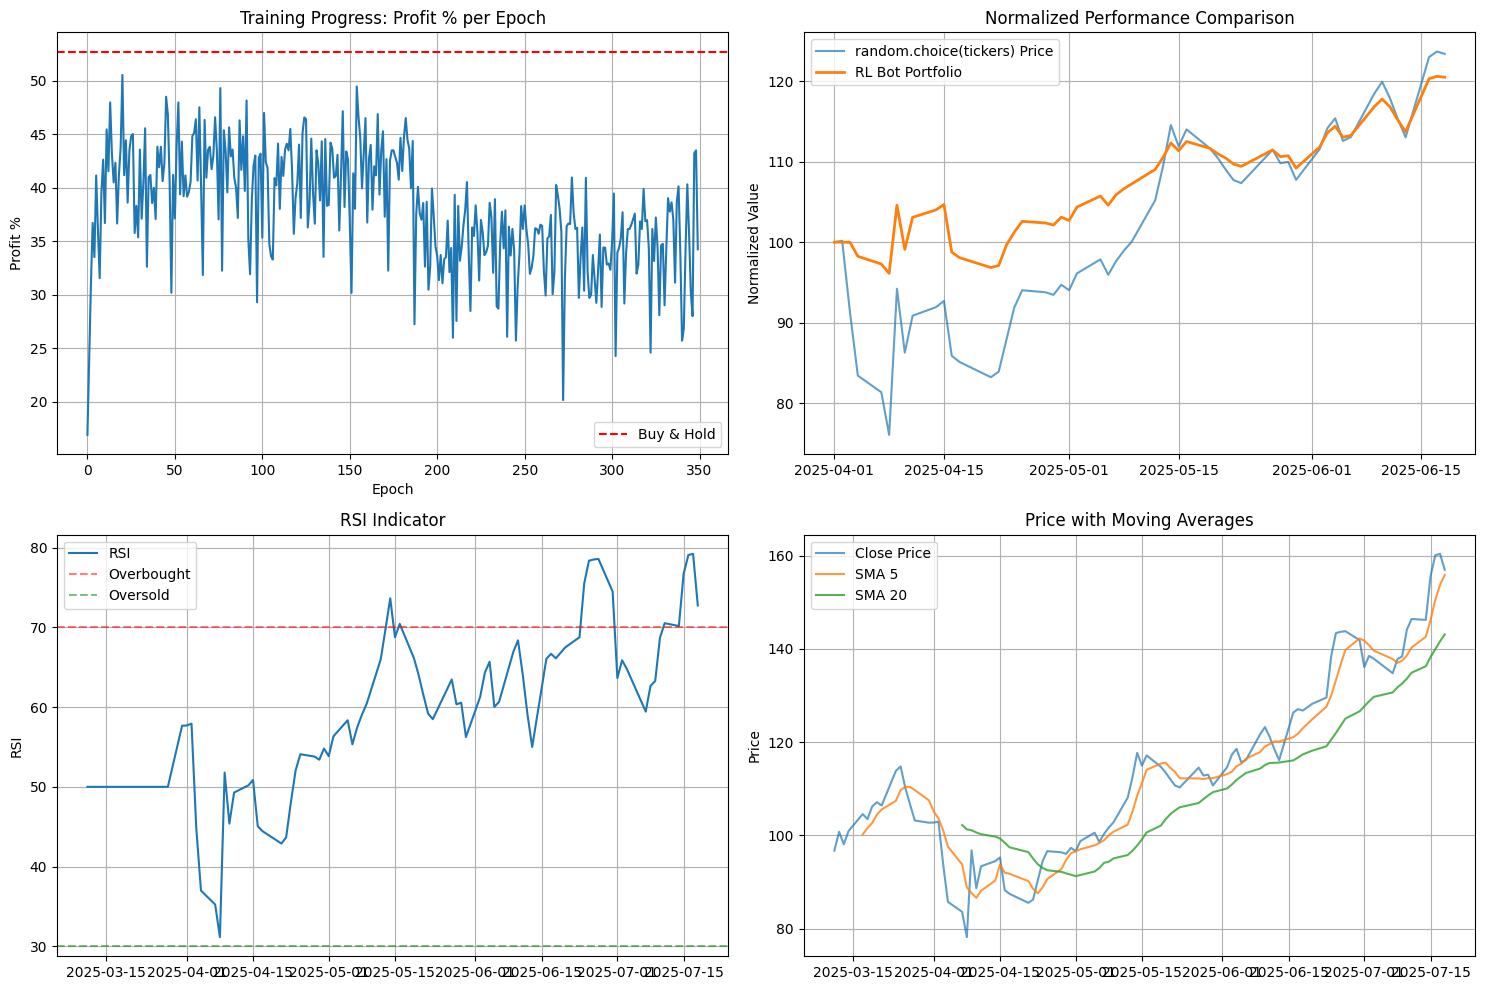

Data length: 90
Portfolio length: 55
Final portfolio value: $120,474.57


In [19]:
# Cell 9 - Enhanced visualization (Fixed)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Portfolio performance over epochs
ax1.plot(epoch_profits)
ax1.axhline(y=buy_hold_profit, color='r', linestyle='--', label='Buy & Hold')
ax1.set_title('Training Progress: Profit % per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Profit %')
ax1.legend()
ax1.grid(True)

# Fix: Ensure portfolio array matches the correct indices
start_idx = 15
end_idx = min(start_idx + len(portfolio_history), len(hist_data))

# Create portfolio series with correct alignment
hist_data['Portfolio'] = np.nan
hist_data.iloc[start_idx:start_idx+len(portfolio_history), hist_data.columns.get_loc('Portfolio')] = portfolio_history

# Price vs Portfolio (normalized) - Fixed indexing
price_subset = hist_data['Close'].iloc[start_idx:end_idx]
portfolio_subset = hist_data['Portfolio'].iloc[start_idx:end_idx].dropna()

price_norm = price_subset / price_subset.iloc[0] * 100
portfolio_norm = portfolio_subset / initial_capital * 100

ax2.plot(price_subset.index, price_norm, label=f'{ticker} Price', alpha=0.7)
ax2.plot(portfolio_subset.index, portfolio_norm, label='RL Bot Portfolio', linewidth=2)
ax2.set_title('Normalized Performance Comparison')
ax2.set_ylabel('Normalized Value')
ax2.legend()
ax2.grid(True)

# RSI with buy/sell signals
ax3.plot(hist_data.index, hist_data['RSI'], label='RSI')
ax3.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
ax3.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
ax3.set_title('RSI Indicator')
ax3.set_ylabel('RSI')
ax3.legend()
ax3.grid(True)

# Moving averages
ax4.plot(hist_data.index, hist_data['Close'], label='Close Price', alpha=0.7)
ax4.plot(hist_data.index, hist_data['SMA_5'], label='SMA 5', alpha=0.8)
ax4.plot(hist_data.index, hist_data['SMA_20'], label='SMA 20', alpha=0.8)
ax4.set_title('Price with Moving Averages')
ax4.set_ylabel('Price')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Data length: {len(hist_data)}")
print(f"Portfolio length: {len(portfolio_history)}")
print(f"Final portfolio value: ${portfolio_history[-1]:,.2f}")